In [ ]:
pip install mtcnn

In [ ]:
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.patches import Circle
from PIL import Image 
from numpy import savez_compressed
from numpy import asarray
from os import listdir
from mtcnn.mtcnn import MTCNN
 
#Extract face
#we convert the image to RGB
#Images needs to be covered to arrays, that's the only way it could be understood
#The we detect using our MTCCN and find the face coordinate (w,h)
def extract_face(image):
  img = Image.open(image)         
  img = img.convert('RGB')        
  pixels = asarray(img1)             
  detector = MTCNN()                 
  find_face = detector.detect_faces(pixels)
  x1,y1,w,h = find_face[0]['box']             
  x1, y1 = abs(x1), abs(y1)
  x2 = abs(x1+w)
  y2 = abs(y1+h)
  #locate the co-ordinates of face in the image
  store_face = pixels[y1:y2,x1:x2]
  plt.imshow(store_face)
  image1 = Image.fromarray(store_face,'RGB')   
#Facenet works with images with size 160 by 160, so we have to resize
  re = image1.resize((160,160))             
  face_array = asarray(re)                  
  return face_array
 
 
#find faces
def load_faces(directory):
  faces = []
  i=1
  for filename in listdir(directory):
    path = directory + filename
    all_faces = extract_image(path)
    faces.append(all_faces)
  return faces
 
 
#Method to get the array of face data(trainX) and it's labels(trainY)
def load_dataset(directory):
  x, y = [],[]
  i=1
  for subdir in listdir(directory):
    path = directory + subdir + '/'
    #load all faces in subdirectory
    faces = load_faces(path)
    #create labels
    labels = [subdir for _ in range(len(faces))]
    #summarize
    print("%d There are %d images in the class %s:"%(i,len(faces),subdir))
    x.extend(faces)
    y.extend(labels)
    i=i+1
  return asarray(x),asarray(y)

1 There are 7 images in the class drbost:
2 There are 7 images in the class asewil:
3 There are 10 images in the class astefa:
4 There are 7 images in the class asamma:
5 There are 8 images in the class ekavaz:
6 There are 7 images in the class anpage:
(46, 160, 160, 3) (46,)


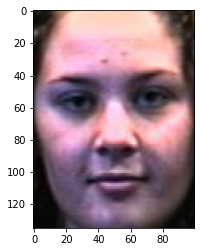

In [ ]:
trainX,trainy =load_dataset(r'/content/drive/My Drive/Colab Notebooks/faces94/train/')
print(trainX.shape,trainy.shape)

1 There are 4 images in the class drbost:
2 There are 4 images in the class anpage:
3 There are 3 images in the class ekavaz:
4 There are 4 images in the class asamma:
5 There are 3 images in the class astefa:
6 There are 4 images in the class asewil:
(22, 160, 160, 3) (22,)


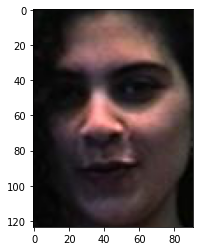

In [ ]:
testX, testY = load_dataset(r'/content/drive/My Drive/Colab Notebooks/faces94/test/')
print(testX.shape,testY.shape)

In [ ]:
 savez_compressed('/arrayface.npz',trainX,trainy, testX, testY)

In [ ]:
from keras.models import load_model
from numpy import load
from numpy import asarray

In [ ]:
 
# load the face dataset
data = load('arrayface.npz')
trainX, trainY, testX, testY = data['arr_0'], data['arr_1'] , data['arr_2'], data['arr_3']
print('Loaded: ', trainX.shape, testX.shape)

Loaded:  (46, 160, 160, 3) (22, 160, 160, 3)


In [ ]:

#This is where Facenet comes in
model = load_model('facenet_keras.h5')
print('Done!')

Loaded Model


In [ ]:
import numpy as np
from numpy import expand_dims
def get_embedding(model, face_pixels):
#convert pixel values to float32
   face_pixels = face_pixels.astype('float32')
# standardize pixel values across channels (global)
   mean, std = face_pixels.mean(), face_pixels.std()
   face_pixels = (face_pixels - mean) / std
# transform face into one sample
   samples = expand_dims(face_pixels, axis=0)
# make prediction to get embedding
   yhat = model.predict(samples)
   return yhat[0]

In [ ]:
from numpy import savez_compressed
from numpy import reshape
newTrainX = list()
for face_pixels in trainX:
    embedding = get_embedding(model, face_pixels)
    newTrainX.append(embedding)
newTrainX = asarray(newTrainX)
print(newTrainX.shape)

(46, 128)


In [ ]:
newTestX = list()
for face_pixels in testX:
 embedding = get_embedding(model, face_pixels)
 newTestX.append(embedding)
newTestX = asarray(newTestX)
print(newTestX.shape)

(22, 128)


In [ ]:
 
#save your new face arrays with Facenet embeddings
savez_compressed('arrayfaces_embeddings.npz', newTrainX, trainY, newTestX, testY)

In [ ]:
 
 
# develop a classifier for the Whole dataset
#we are gonna use SVM for classification
from numpy import load
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
# load dataset
data = load('arrayfaces_embeddings.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Dataset: train=%d, test=%d' % (trainX.shape[0], testX.shape[0]))
# normalize input vectors
in_encoder = Normalizer(norm='l2')
trainX = in_encoder.transform(trainX)
testX = in_encoder.transform(testX)
# label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
testy = out_encoder.transform(testy)
# fit model
model = SVC(kernel='linear', probability=True)
model.fit(trainX, trainy)
# predict
yhat_train = model.predict(trainX)
yhat_test = model.predict(testX)
# score
score_train = accuracy_score(trainy, yhat_train)
score_test = accuracy_score(testy, yhat_test)
# summarize
print('Accuracy: train=%.3f, test=%.3f' % (score_train*100, score_test*100))

Dataset: train=46, test=22
Accuracy: train=100.000, test=100.000


In [ ]:
 
#Now, let's test our predicitons on a randomly picked test image
from random import choice
from numpy import load
from numpy import expand_dims
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
from matplotlib import pyplot
# load faces
data = load('arrayface.npz')
testX_faces = data['arr_2']
# load face embeddings
data = load('arrayfaces_embeddings.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
# normalize input vectors
in_encoder = Normalizer(norm='l2')
trainX = in_encoder.transform(trainX)
testX = in_encoder.transform(testX)
# label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
testy = out_encoder.transform(testy)
# fit model
model = SVC(kernel='linear', probability=True)
model.fit(trainX, trainy)
# test model on a random example from the test dataset
selection = choice([i for i in range(testX.shape[0])])
random_face_pixels = testX_faces[selection]
random_face_emb = testX[selection]
random_face_class = testy[selection]
random_face_name = out_encoder.inverse_transform([random_face_class])
# prediction for the face
samples = expand_dims(random_face_emb, axis=0)
yhat_class = model.predict(samples)
yhat_prob = model.predict_proba(samples)
# get name
class_index = yhat_class[0]
class_probability = yhat_prob[0,class_index] * 100
predict_names = out_encoder.inverse_transform(yhat_class)
print('Predicted: %s (%.3f)' % (predict_names[0], class_probability))
print('Expected: %s' % random_face_name[0])
# plot for visibility
pyplot.imshow(random_face_pixels)
title = '%s (%.3f)' % (predict_names[0], class_probability)
pyplot.title(title)
pyplot.show()